# Imports

In [1]:
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

from src.data.tiny_imagenet_dataset import SmallImageNetTrainDataset

# Data

In [2]:
image_size = 512

In [3]:
transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SmallImageNetTrainDataset(
        root_dir=r"F:\\research\data\\small_imagenet_object_loc\\train",
        classes_names_path=r"F:\\research\\data\\small_imagenet_object_loc\\classes_names.txt",
        transform=transform
)

In [4]:
sample = dataset[10000]
image = sample["image"]
label = sample["label_encoded"]
image_tag = sample["tag"]

In [5]:
image.shape, label

(torch.Size([3, 512, 512]), 100)

In [6]:
# train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# image, label = train_dataset[0]
# label

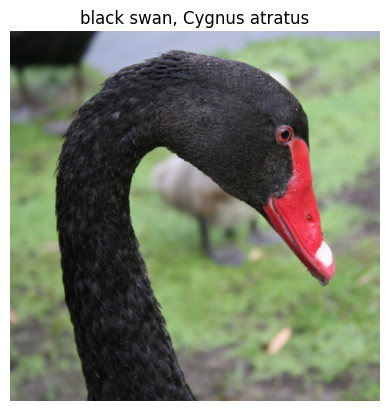

In [7]:
plt.title(f"{dataset.classes_names[image_tag]}")
plt.axis('off')
plt.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)

# SVD

In [8]:
image.shape

torch.Size([3, 512, 512])

In [9]:
image = image.unsqueeze(0)
image.shape

torch.Size([1, 3, 512, 512])

In [10]:
from src.tokenizers.svd_tokenizer import SVDLinearTokenizer

In [11]:
img_batch = torch.cat([image] * 32, dim=0)

In [12]:
tokenizer = SVDLinearTokenizer(image_size=image_size, num_channels=3, embedding_dim=768, dispersion=0.9, full_matrices=False)

In [13]:
approx_U, approx_S, approx_V, rank = tokenizer.get_approx_svd(image[0])

In [14]:
rank

102

In [15]:
reconstructed_image = tokenizer.reconstruct_image(approx_U, approx_S, approx_V)
reconstructed_image.shape

torch.Size([3, 512, 512])

In [16]:
# rank = 50
# 
# approx_image_channels = []
# for image_channel in image:
#     U, S, Vh = torch.linalg.svd(image_channel)
#     approx_image_channel = (U[:, :rank] @ torch.diag(S[:rank]) @ Vh[:rank, :])
#     approx_image_channels.append(approx_image_channel)
#     
# approx_image = torch.stack(approx_image_channels)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0119116865..1.0205135].


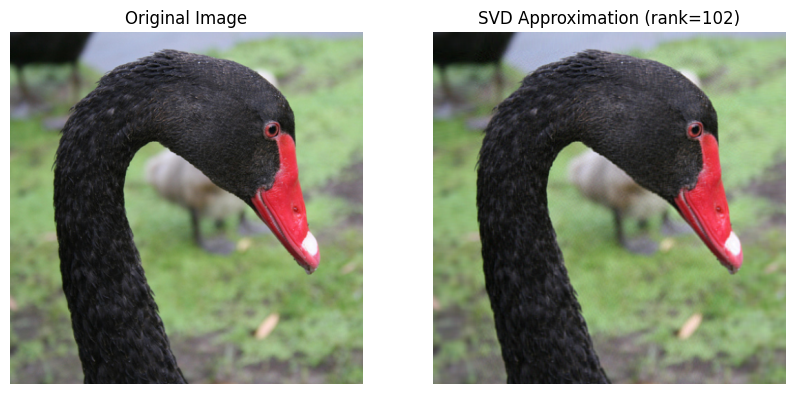

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image[0].permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(reconstructed_image.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)
axes[1].set_title(f"SVD Approximation (rank={rank})")
axes[1].axis("off")

plt.show()

## Tokenization

In [18]:
img_batch.shape

torch.Size([32, 3, 512, 512])

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
tokenizer = tokenizer.to(device)
img_batch = img_batch.to(device)

In [21]:
embedding = tokenizer(img_batch)

In [22]:
embedding.shape

torch.Size([32, 103, 768])

# SVD dispersion

In [43]:
image.shape

torch.Size([1, 3, 512, 512])

In [23]:
U, S, Vh = torch.linalg.svd(image, full_matrices=True)
Vh = Vh.mH

## Linear

In [24]:
S_sum = S.sum(dim=0, keepdim=True)

S_cumsum = torch.cumsum(S_sum, dim=1)
total_sum = S_sum.sum()

S_cumsum_norm = S_cumsum / total_sum

In [25]:
S_cumsum_norm_lin = S_cumsum_norm.squeeze().numpy()

## Quadratic

In [26]:
S_squared = torch.square(S)
S_squared = S_squared.sum(dim=0, keepdim=True)

S_cumsum = torch.cumsum(S_squared, dim=1)
total_sum = S_squared.sum()

S_cumsum_norm = S_cumsum / total_sum

In [27]:
S_cumsum_norm_quad = S_cumsum_norm.squeeze().numpy()

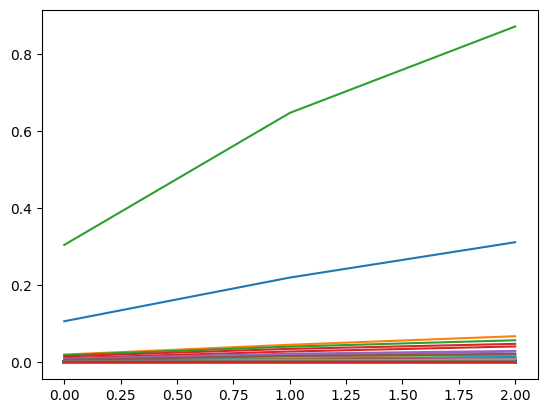

In [28]:
plt.plot(S_cumsum_norm_lin)
plt.plot(S_cumsum_norm_quad)

# Check random transforms

In [29]:
transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SmallImageNetTrainDataset(
        root_dir=r"F:\\research\data\\small_imagenet_object_loc\\train",
        classes_names_path=r"F:\\research\\data\\small_imagenet_object_loc\\classes_names.txt",
        transform=transform
)

In [30]:
sample = dataset[10000]
image_base = sample["image"]
label = sample["label_encoded"]
image_tag = sample["tag"]

In [31]:
random_transform = transforms.Compose([
        transforms.Resize((
            int(image_size * 1.25),
            int(image_size * 1.25)
        )),
        transforms.RandomCrop(image_size),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
])

dataset_aug = SmallImageNetTrainDataset(
        root_dir=r"F:\\research\data\\small_imagenet_object_loc\\train",
        classes_names_path=r"F:\\research\\data\\small_imagenet_object_loc\\classes_names.txt",
        transform=random_transform
)

In [32]:
sample_aug = dataset_aug[10000]
image_aug = sample_aug["image"]
label_aug = sample_aug["label_encoded"]
image_tag_aug = sample_aug["tag"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


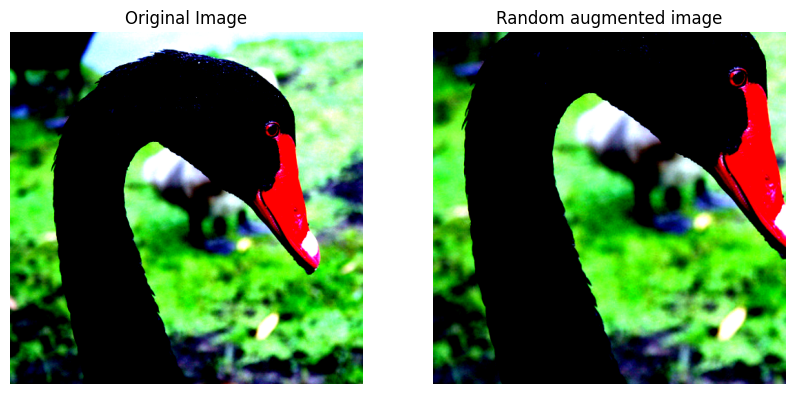

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image_base.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image_base.shape[0] == 1 else None)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(image_aug.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image_aug.shape[0] == 1 else None)
axes[1].set_title(f"Random augmented image")
axes[1].axis("off")

plt.show()

In [34]:
approx_U_base, approx_S_base, approx_V_base, rank_base = tokenizer.get_approx_svd(image_base)
rank_base

122

In [35]:
approx_U_aug, approx_S_aug, approx_V_aug, rank_aug = tokenizer.get_approx_svd(image_aug)
rank_aug

109

In [36]:
n_channels, im_sz, rnk_base = approx_U_base.shape
approx_U_base = torch.reshape(approx_U_base, (n_channels * rnk_base, im_sz))
approx_U_base.shape

torch.Size([366, 512])

In [37]:
n_channels, im_sz, rnk_aug = approx_U_aug.shape
approx_U_aug = torch.reshape(approx_U_aug, (n_channels * rnk_aug, im_sz))
approx_U_aug.shape

torch.Size([327, 512])

In [38]:
cos_sim = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

In [39]:
output_U = cos_sim(approx_U_base[0:min(rnk_base, rnk_aug)], approx_U_aug[0:min(rnk_base, rnk_aug)])
output_U.abs().sum() / output_U.shape[0]

tensor(0.0366)

In [40]:
n_channels, im_sz, rnk_base = approx_V_base.shape
approx_V_base = torch.reshape(approx_V_base, (n_channels * rnk_base, im_sz))
approx_V_base.shape

torch.Size([366, 512])

In [41]:
n_channels, im_sz, rnk_base = approx_V_aug.shape
approx_V_aug = torch.reshape(approx_V_aug, (n_channels * rnk_base, im_sz))
approx_V_aug.shape

torch.Size([327, 512])

In [42]:
output_V = cos_sim(approx_V_base[0:min(rnk_base, rnk_aug)], approx_V_aug[0:min(rnk_base, rnk_aug)])
output_V.abs().sum() / output_V.shape[0]

tensor(0.0355)